In [8]:
!pip install datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.2/254.2 kB 6.7 MB/s eta 0:00:00ta 0:00:01


In [49]:
import pandas as pd
from tqdm import tqdm
from heapq import nlargest
from datetime import timedelta
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
"""读取json文件"""
sample_size = 150000
chunks = pd.read_json("../input/otto-recommender-system/train.jsonl", lines=True, chunksize=sample_size)
for c in chunks:
    sample_train_df = c
    break
c

,session,events
0,0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."
3,3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':..."
4,4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ..."
...,...,...
149995,149995,"[{'aid': 443027, 'ts': 1659332465408, 'type': ..."
149996,149996,"[{'aid': 1849006, 'ts': 1659332465484, 'type':..."
149997,149997,"[{'aid': 135905, 'ts': 1659332465575, 'type': ..."
149998,149998,"[{'aid': 288928, 'ts': 1659332465804, 'type': ..."


In [3]:
"""重构 DataFrame，使得 session 列的值作为索引"""
sample_train_df.set_index('session', drop=True, inplace=True)
sample_train_df.head()

,events
session,
0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."
3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':..."
4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ..."


In [4]:
"""看一下数据中的前两个session"""
example_session = sample_train_df.iloc[0].item()
print(f'This session was {len(example_session)} actions long')
print(f'The first action in the session: \n {example_session[0]} \n {example_session[1]}')

This session was 276 actions long
The first action in the session: 
 {'aid': 1517085, 'ts': 1659304800025, 'type': 'clicks'} 
 {'aid': 1563459, 'ts': 1659304904511, 'type': 'clicks'}


In [12]:
"""看一下会话的时间跨度"""
time_elapsed = example_session[-1]["ts"] - example_session[0]["ts"]
print(f'The first session elapsed: {str(timedelta(milliseconds=time_elapsed))} \n')

The first session elapsed: 27 days, 13:09:43.682000 



In [16]:
"""统计session中每个action出现的频率"""
action_counts = defaultdict(int)
for action in example_session:
    action_counts[action['type']] += 1
print(f'The first session contains the following frequency of actions: {action_counts}')

The first session contains the following frequency of actions: defaultdict(<class 'int'>, {'clicks': 255, 'carts': 17, 'orders': 4})


In [18]:
"""从每个session中提取信息，并将其添加到df中"""
action_counts_list, article_id_counts_list, session_length_time_list, session_length_action_list = ([] for i in range(4))
overall_action_counts = defaultdict(int)
overall_article_id_counts = defaultdict(int)
for i, row in tqdm(sample_train_df.iterrows(), total=len(sample_train_df)):
    actions = row['events']

    action_counts = defaultdict(int)
    article_id_counts = defaultdict(int)
    for action in actions:
        action_counts[action['type']] += 1
        article_id_counts[action['aid']] += 1
        overall_action_counts[action['type']] += 1
        overall_article_id_counts[action['aid']] += 1

    # 得到当前session的时间跨度
    session_length_time = actions[-1]['ts'] - actions[0]['ts']

    # 添加到列表中
    action_counts_list.append(action_counts)
    article_id_counts_list.append(article_id_counts)
    session_length_time_list.append(session_length_time)
    session_length_action_list.append(len(actions))

sample_train_df['action_counts'] = action_counts_list
sample_train_df['article_id_counts'] = article_id_counts_list
sample_train_df['session_length_unix'] = session_length_time_list
sample_train_df['session_length_hours'] = sample_train_df['session_length_unix']*2.77778e-7  # Convert to hours
sample_train_df['session_length_action'] = session_length_action_list

100%|██████████| 150000/150000 [00:27<00:00, 5469.30it/s]


overall_action_counts:dict_values([7121618, 565237, 154972])


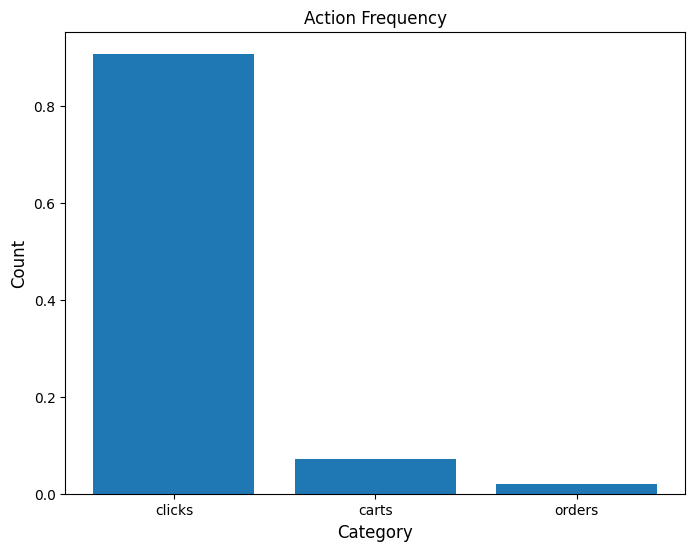

In [26]:
print(f'overall_action_counts:{overall_action_counts.values()}')
n = sum(overall_action_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(list(overall_action_counts.keys()), [val / n for val in overall_action_counts.values()])
plt.title("Action Frequency", fontsize=12)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Length of each session')

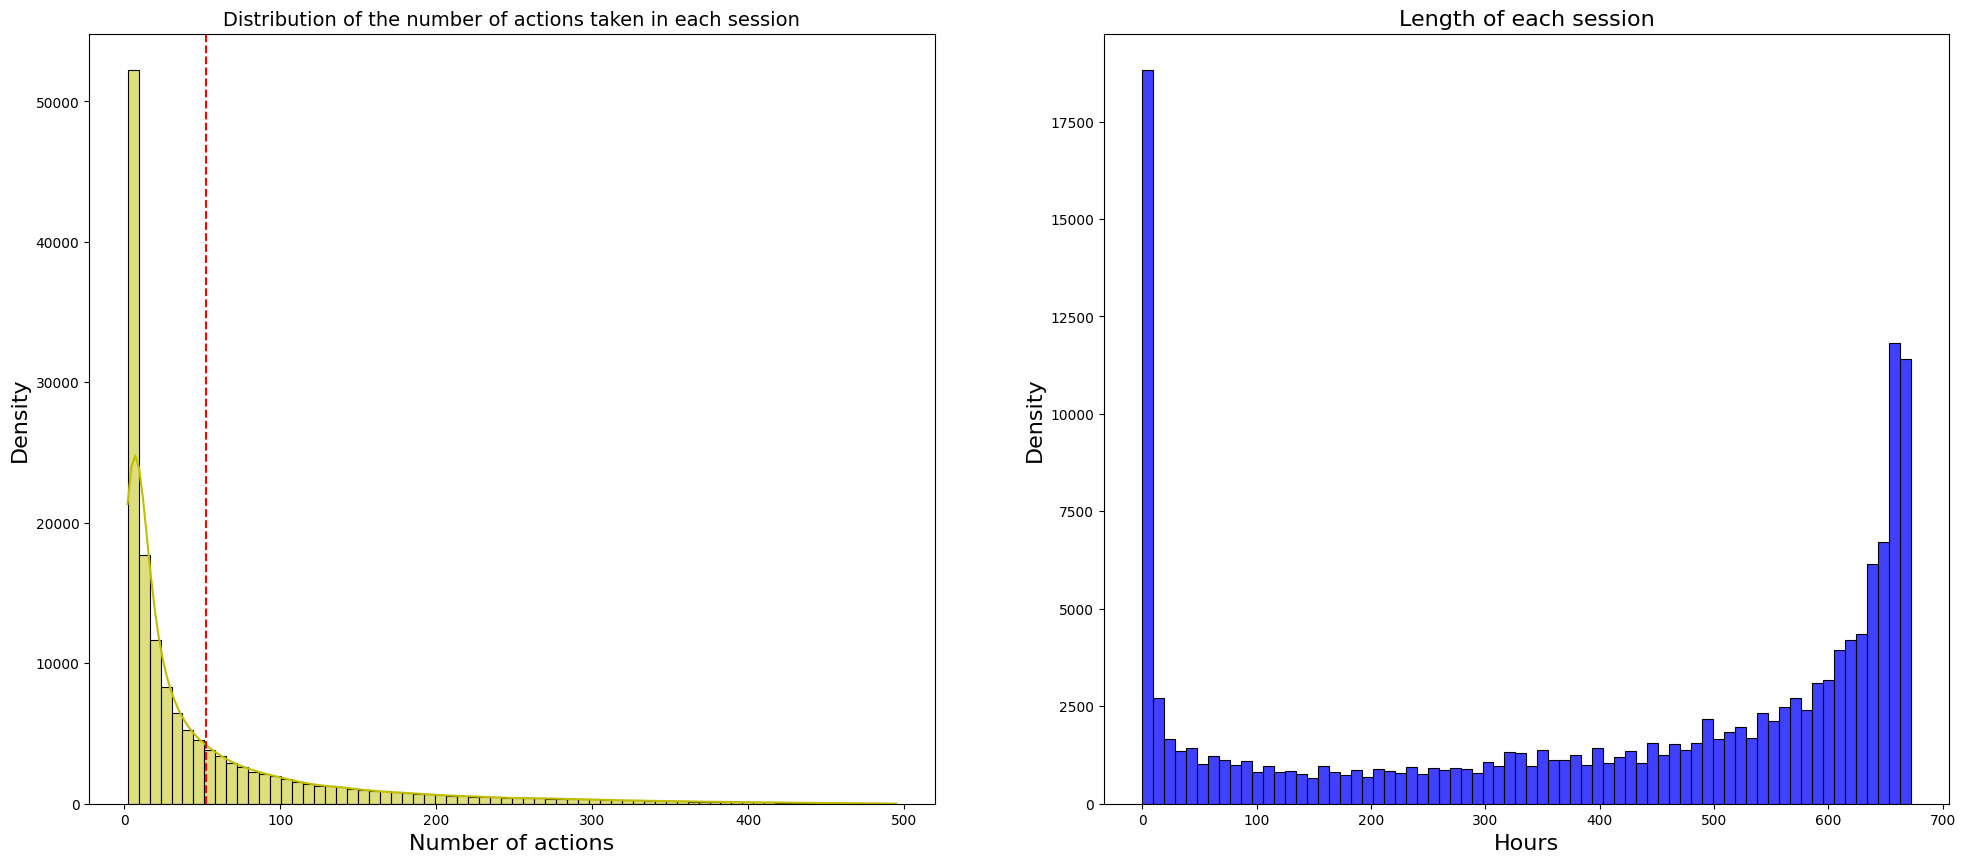

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(24, 10))

p = sns.histplot(sample_train_df['session_length_action'], color="y", bins= 70, ax=ax[0], kde=True)
p.set_xlabel("Number of actions", fontsize = 16)
p.set_ylabel("Density", fontsize = 16)
p.set_title("Distribution of the number of actions taken in each session", fontsize = 14)
p.axvline(sample_train_df['session_length_action'].mean(), color='r', linestyle='--', label="Mean")

p = sns.histplot(sample_train_df['session_length_hours'], color="b", bins= 70, ax=ax[1], kde=False)
p.set_xlabel("Hours", fontsize = 16)
p.set_ylabel("Density", fontsize = 16)
p.set_title("Length of each session", fontsize = 16)

In [40]:
print(f'{round(len(sample_train_df[sample_train_df["session_length_action"] < 10]) / len(sample_train_df), 3) * 100}% of the sessions had less than 10 actions')

34.8% of the sessions had less than 10 actions


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Count')

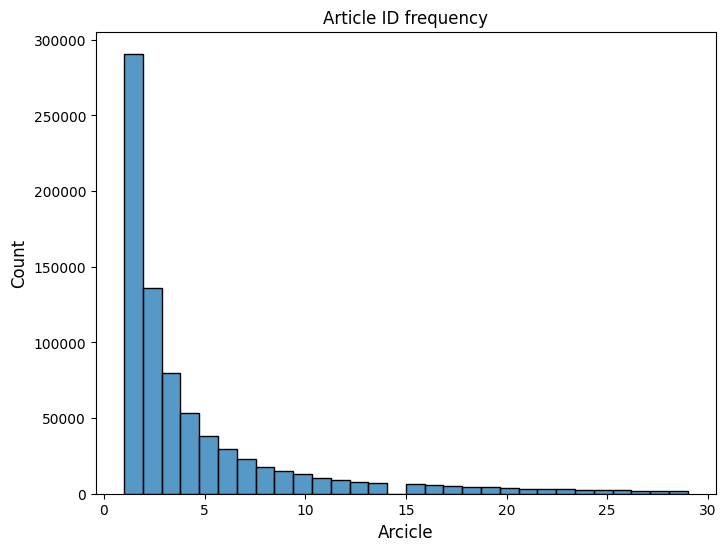

In [42]:
article_id_freq = list(overall_article_id_counts.values())
cut_off = [i for i in article_id_freq if i < 30]

plt.figure(figsize=(8, 6))
sns.histplot(cut_off, bins=30, kde=False)
plt.title(f'Article ID frequency', fontsize=12)
plt.xlabel('Arcicle', fontsize=12)
plt.ylabel('Count', fontsize=12)

In [50]:
### Look at the most interacted with articles ###
print(f'Frequency of most common articles: {sorted(list(overall_article_id_counts.values()))[-5:]} \n')
res = nlargest(5, overall_article_id_counts, key = overall_article_id_counts.get)
print(f'IDs for those common articles: {res}')

Frequency of most common articles: [3877, 4259, 4323, 4503, 5000] 

IDs for those common articles: [29735, 1603001, 832192, 1733943, 108125]
